In [1]:
#VISUALIZATION
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# GET USER DATA
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import re
from tqdm import tqdm
import threading
import time
import requests
from concurrent.futures import ThreadPoolExecutor

# NLTK
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud

# MODEL
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification, AdamW, BertConfig, DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import os
import pickle

# DATA COLLECTION AND PREPROCESSING

In [ ]:
sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        client_id ='bfaec60a7e8945c8b1dd7c2826a53250',
        client_secret = '1df46ed112ba4edf8e9885d59df89ff0',
        redirect_uri = 'http://localhost:8889/',
        scope="user-library-read user-top-read",
    )
)
sp

In [ ]:
def get_user_playlists(user_link):
    try:
        user_id = re.search('(?<=user\/).+(?=\?)', user_link).group()
        return user_id, sp.user_playlists(user_id)
    except:
        return None, None

input_user_link = input('Enter your spotify profile link')
user_id, playlists = get_user_playlists(input_user_link)

playlist_songs = []

if playlists:
    for i, playlist in enumerate(playlists['items']):
        playlist_attr = (playlist['name'], playlist['external_urls']['spotify'])
        playlist_songs.append( playlist_attr )
        print("%4d %s"%(i + 1, playlist['name']))
else:
    print('User not found')

In [ ]:
playlists_id = []

for song in playlist_songs:
    try:
        id_ = re.search('(?<=playlist\/).+',song[1]).group()
        playlists_id.append(id_)
    except:
        continue
        
playlists_id

In [ ]:
def get_track_playlistId(playlist_id):
    results = sp.playlist_items(playlist_id)
    songs = results['items']
    
    output = []

    i = 0
    while results['next']:
        i += 1
        results = sp.next(results)
        songs.extend(results['items'])
        
    for song in tqdm(songs):
        songid = song['track']['id']
        songname = song['track']['name']
        songartists = []
        for artist in song['track']['artists']:
            songartists.append(artist['name'])
        if (songname,songartists) not in output:
            output.append((songid,songname,songartists))
            
    return output

song_in_playlist = []
for playlist in playlists_id:
    song_in_playlist.append( get_track_playlistId(playlist) )

In [ ]:
temp = []

for playlist in song_in_playlist:
    for song in playlist:
        temp.append(song)
song_in_playlist = temp
len(song_in_playlist)

In [ ]:
def get_lyrics(name,artist):
    try:
        response = requests.get(f"https://api.lyrics.ovh/v1/{artist}/{name}")
        response.raise_for_status()
        data = response.json().get('lyrics')
        return data
    except Exception as e :
        # print(e)
        return None

all_lyrics = [None] * len(song_in_playlist)
def get_song(index, each):
    # time.sleep(2)
    try:
        song = get_lyrics(each[1], each[2][0])
        all_lyrics[index] = song
    except Exception as e:
        all_lyrics[index] = None
        print(f"Error fetching song {index}: {e}")

with ThreadPoolExecutor(max_workers=100) as executor:
    list(tqdm(executor.map(lambda i: get_song(i[0], i[1]), enumerate(song_in_playlist)), total=len(song_in_playlist)))

## Gather data from relevant sources - more than 10k rows, minimum 5k.

In [142]:
data = pd.read_csv('emotion_dataset_raw.csv')
data = data[:10000] # take only some parts of this
data['Emotion'].value_counts()

Emotion
joy         3250
sadness     1866
fear        1507
anger       1271
surprise    1183
neutral      633
disgust      247
shame         43
Name: count, dtype: int64

In [144]:
data.shape

(10000, 2)

## Clean and preprocess the data.

## Handle missing values and outliers.

In [146]:
data.isna().sum()

Emotion    0
Text       0
dtype: int64

## Perform feature engineering

In [149]:
data.head(5)

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


In [168]:
data.head()

,Emotion,Text,Text length,Cleaned text
0,neutral,Why ?,2,Why
1,joy,Sage Act upgrade on my to do list for tommorow.,10,Sage Act upgrade list tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,20,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...,102,Such eye The true hazel eye-and brilliant Regu...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,22,@Iluvmiasantos ugh babe.. hugggzzz u .! babe n...


In [166]:
data['Text length'] = data['Text'].apply(lambda x: len(x.split()))

average_text_length = data['Text length'].mean().round(2)
emotion_counter = data['Emotion'].value_counts()

stop_words = set(stopwords.words('english'))
custom_stop_words = {"i'd", "we're", "i", "i've", "i'm", "you're", "don't", "i'll", "can't", "it's",'.',',','!','?','&amp;',"'","'s"}
stop_words.update(custom_stop_words)

data['Cleaned text'] = data['Text'].apply(lambda x: " ".join([e for e in x.split() if e not in stop_words]))

all_words = data['Text'].values
all_words = ' '.join(all_words)
all_words = all_words.split()
all_words = " ".join([word for word in all_words if word.lower() not in stop_words]).split()
freq_dist = FreqDist(all_words)
a = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
top_5_words = a[:5]


print(f'''
Average text length in train data: {average_text_length} words

Emotions counter in train data: 
{emotion_counter}

Top 5 words in train data:
{top_5_words}
''')


Average text length in train data: 16.23 words

Emotions counter in train data: 
Emotion
joy         3250
sadness     1866
fear        1507
anger       1271
surprise    1183
neutral      633
disgust      247
shame         43
Name: count, dtype: int64

Top 5 words in train data:
[('get', 390), ('like', 377), ('time', 375), ('one', 328), ('day', 328)]



# Exploratory Data Analysis (EDA)

## Conduct descriptive statistics, visualize data distributions and relationships, Identify patterns and trends.

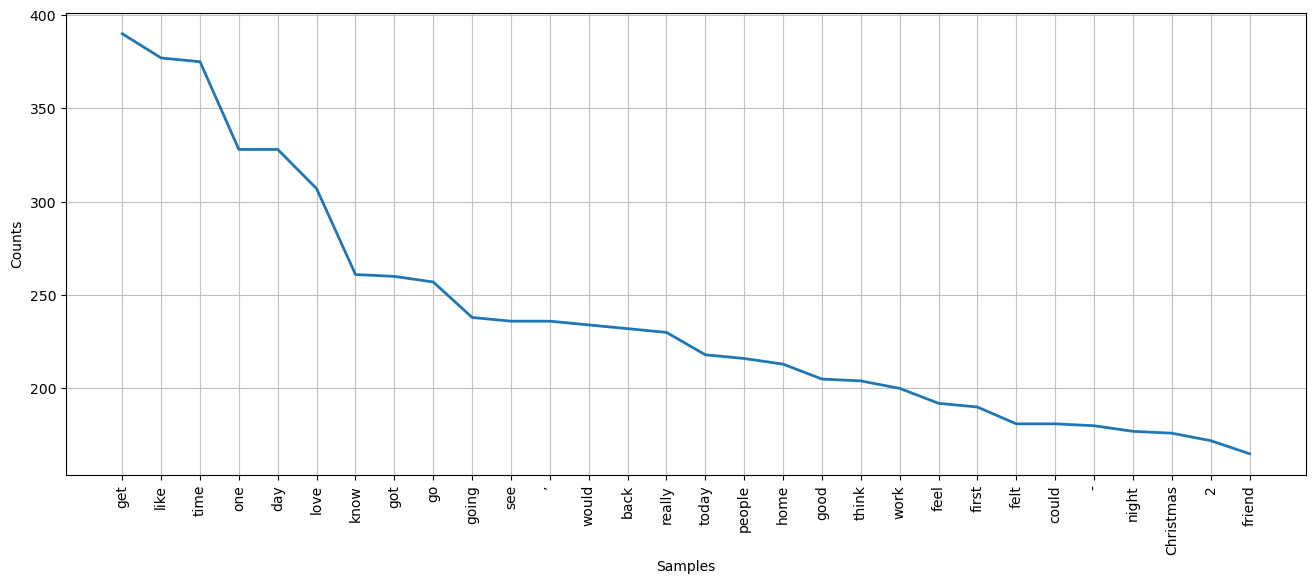

In [170]:
plt.figure(figsize=(16,6))
freq_dist.plot(30)
plt.show()

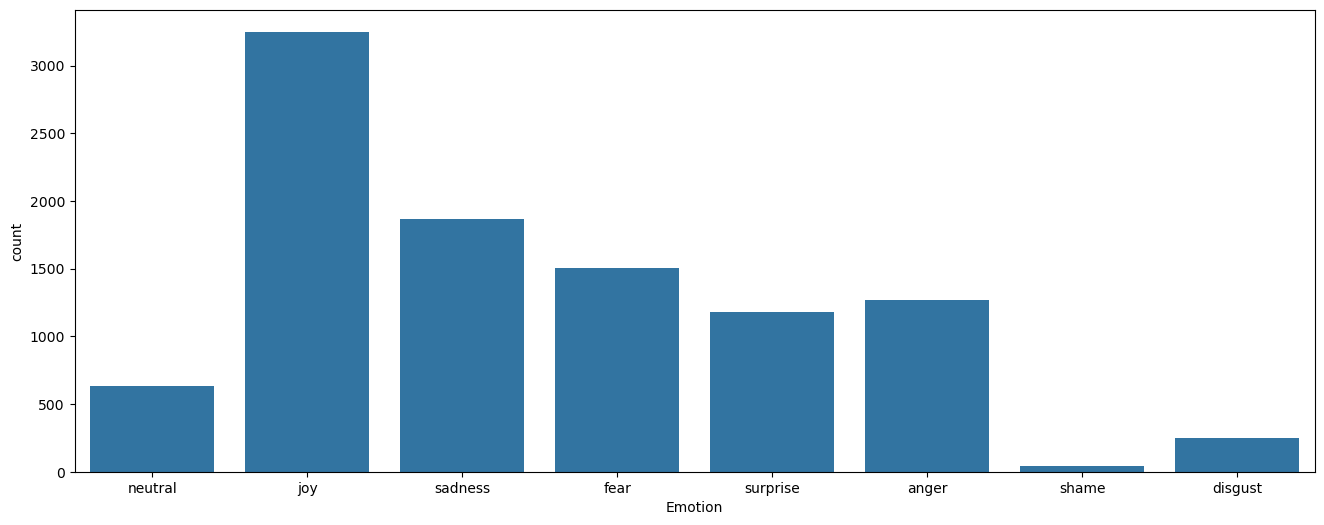

In [172]:
plt.figure(figsize=(16,6))
sns.countplot(
    x=data['Emotion']
)
plt.show()

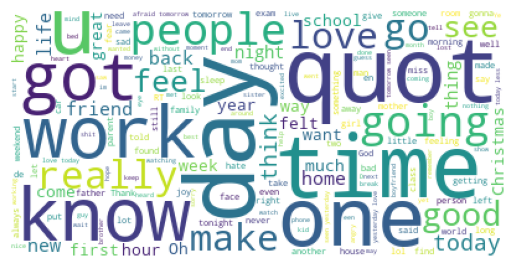

In [282]:
wc = WordCloud(background_color='white').generate(' '.join(all_words))
plt.imshow(wc)
plt.grid(False)
plt.axis(False)
plt.show()

# DEEP LEARNING MODEL DEVELOPMENT

## Training/developing model

In [214]:
torch.manual_seed(42)
np.random.seed(42)

# configurations
max_length = 128
batch_size = 16
epochs = 5
learning_rate = 0.00002
device = torch.device('cpu') # dont have gpu >.<

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

le = LabelEncoder()
y = le.fit_transform(data['Emotion'])

print("Label encoder classes:", le.classes_)

# class weights
class_counts = pd.Series(y).value_counts()
total = len(y)
class_weights = torch.tensor(
    [total / (len(class_counts) * count) for count in class_counts],
    dtype=torch.float32
).to(device)

x_train, x_test, y_train, y_test = train_test_split(data['Cleaned text'], y, test_size=0.2, stratify=y, random_state=42)

# tokenize
train_tokens = tokenizer(list(x_train), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
test_tokens = tokenizer(list(x_test), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Label encoder classes: ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'shame' 'surprise']


In [222]:
# model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(le.classes_)).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, epochs=epochs, steps_per_epoch=len(train_loader))

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# training loop
best_loss = float('inf')
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    
    # save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'emotion_model.pt')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [12:31<00:00,  1.50s/it]


Epoch 1/5, Loss: 1.3820


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [12:26<00:00,  1.49s/it]


Epoch 2/5, Loss: 0.8628


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [12:14<00:00,  1.47s/it]


Epoch 3/5, Loss: 0.6190


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [12:14<00:00,  1.47s/it]


Epoch 4/5, Loss: 0.3809


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [12:03<00:00,  1.45s/it]


Epoch 5/5, Loss: 0.2838


In [228]:
# evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

pred_labels = le.inverse_transform(all_preds)
true_labels = le.inverse_transform(all_labels)

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 125/125 [00:43<00:00,  2.88it/s]


Classification Report:
              precision    recall  f1-score   support

       anger       0.72      0.25      0.37       254
     disgust       0.00      0.00      0.00        49
        fear       0.66      0.63      0.65       301
         joy       0.67      0.68      0.67       650
     neutral       0.67      0.75      0.71       127
     sadness       0.49      0.69      0.57       373
       shame       0.35      0.89      0.50         9
    surprise       0.45      0.53      0.49       237

    accuracy                           0.59      2000
   macro avg       0.50      0.55      0.49      2000
weighted avg       0.60      0.59      0.57      2000




C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [232]:
output_dir = 'emotion_model_latest'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

with open(os.path.join(output_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)

print("saved")

saved


## Using model

In [238]:
device = 'cpu'
tokenizer = DistilBertTokenizer.from_pretrained('emotion_model_latest')

model = DistilBertForSequenceClassification.from_pretrained('emotion_model_latest').to(device)
model.eval()

with open('emotion_model_latest/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

print("loaded")

loaded


In [250]:
def detect_emotions(lyrics):
    tokens = tokenizer(lyrics, padding=True, truncation=True, max_length=128, return_tensors='pt')
    tokens = {key: value.to(device) for key, value in tokens.items()}

    with torch.no_grad():
        outputs = model(**tokens)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
    
    predicted_emotion = label_encoder.inverse_transform(preds.cpu().numpy())[0]
    probabilities = {emotion: float(prob) for emotion, prob in zip(label_encoder.classes_, probs.cpu().numpy()[0])}
    
    return {
        "predicted_emotion": predicted_emotion,
        "probabilities": probabilities
    }

In [252]:
test_lyrics = "i'm happy"

emotions = detect_emotions(test_lyrics)
print("Detected Emotions:", emotions)

Detected Emotions: {'predicted_emotion': 'joy', 'probabilities': {'anger': 0.012266380712389946, 'disgust': 0.006360350642353296, 'fear': 0.008404823951423168, 'joy': 0.7579892873764038, 'neutral': 0.029823172837495804, 'sadness': 0.16264232993125916, 'shame': 0.0024321868550032377, 'surprise': 0.020081503316760063}}
